In [29]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
import time
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import hstack
import datetime as dt

import math
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 35, 40
%matplotlib inline

import matplotlib.cm as cm
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import __version__
from plotly import graph_objs as go
from plotly.graph_objs import *

## Читаем данные

In [30]:
df=pd.read_pickle('MG_Sales_customer.pickle',compression='gzip')

In [31]:
#---------------------------
#выбираем покупателей для дальнейшего анализа
sales_sum=df.groupby('Покупатель')['Количество'].sum().sort_values()
#выкидываем со слишком большими продажами (сводные карты) и тех кто купил один раз
sales_sum.drop(sales_sum[(sales_sum>sales_sum.tail(6)[0])].index, inplace=True)#|(sales_sum==1)
customers_name=list(sales_sum.index)
del sales_sum

#делаем выборку
select=df.loc[(df['Покупатель'].isin(customers_name))&(df['Дата']>=(dt.datetime(2015,1,1))),['Покупатель','ПокупательПол','ПокупательДатаРождения','ВидИзделия','ПодвидИзделия','СтильДизайна','ВидДизайна','ОсновнойКамень','ГруппаТовара','Коллекция','ЦветМеталла','ТоварСреднийВес','Размер','Вес','Количество','Сумма','Дата','ПокупательОтказОтСМС']]
del customers_name
del df

#Подготовка датасета
#ЦветМеталла=list(map(lambda xx: xx,list(select['ЦветМеталла'].unique())))
def codeMetall(_str):    
    for str_split in _str.lower().split():
        if str_split=='серебро': return 0
        if str_split=='золото': return 10
        if str_split=='зол.': return 11
        if str_split=='платина': return 20
        if str_split=='сплав': return -10
    return -20


select['ПокупательПолКод']=select['ПокупательПол'].map(lambda xx: {'Ж':0, 'М':1, '<Неопределено>':None}[xx])
select['ЦветМеталлаКод']=select['ЦветМеталла'].map(lambda xx: codeMetall(xx))
select['ПокупательПолКод'].fillna(select['ПокупательПолКод'].median(),inplace=True)
select['ПокупательГодРождения']=select['ПокупательДатаРождения'].dt.year
select['ПокупательГодРождения']=select['ПокупательГодРождения'].map(lambda xx: None if xx<1917 else xx)
select['ПокупательГодРождения']=select['ПокупательГодРождения'].map(lambda xx: None if xx>2010 else xx)
#select['ПокупательГодРождения'].fillna(select['ПокупательГодРождения'].median(),inplace=True)
select.drop(['ПокупательДатаРождения','ЦветМеталла','ПокупательПолКод'],  axis=1, inplace=True)
#выборка колонок
numerical_columns = [c for c in select.columns if select[c].dtype.name != 'object']
categorial_columns = [c for c in select.columns if select[c].dtype.name == 'object']

numerical_columns=list(set(numerical_columns)-(set(['ПокупательГодРождения','Дата','Сумма'])))
categorial_columns=list(set(categorial_columns)-(set(['ПокупательПол','ПокупательОтказОтСМС'])))



#Dummy-кодирование и шкалируем
lb_style = LabelBinarizer(sparse_output=True)
#colsNames=pd.DataFrame(data=numerical_columns,columns=['Колонки'])


#concList=[]
for col in categorial_columns:
    concList.append(lb_style.fit_transform(select[col]))    
    #colsNames=colsNames.append(pd.DataFrame(data=lb_style.classes_,columns=['Колонки']))
#concList.append(StandardScaler().fit_transform(select[numerical_columns]))#добавляем шклированные значения числовых переменных
X=hstack(concList)
#colsNames=colsNames.reset_index()

del concList
print('shape ',X.shape)
#print('shape colsNames ',colsNames.shape)
print('Prepare finished')

shape  (200464, 94540)
shape colsNames  (94540, 2)
Prepare finished


In [32]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=133, n_iter=7)
svd_representation = svd.fit_transform(X)
print('reduced')

reduced


In [33]:
del X

In [50]:
# print("start")
hdb_t1 = time.time()
n_clusters=10

hdb = HDBSCAN(min_cluster_size=3650,min_samples=1,core_dist_n_jobs=8,metric='manhattan',alpha=.0001).fit(svd_representation)#,metric='manhattan' alpha=.00001,
#hdb = MiniBatchKMeans(n_clusters=n_clusters,max_iter=150,max_no_improvement=15,batch_size=165,tol=.01,n_init=5,random_state=17).fit(svd_representation)
#hdb = MiniBatchKMeans(n_clusters=n_clusters,max_iter=150,max_no_improvement=15,batch_size=260,tol=.0094,n_init=5,random_state=17).fit(svd_representation)


hdb_elapsed_time = time.time() - hdb_t1
print('HDBSCAN Elapsed time to cluster: %6.1f m' % (hdb_elapsed_time/60))

n_clusters = len(set(hdb.labels_)) - (1 if -1 in hdb.labels_ else 0)
print("n_clusters =", n_clusters)

HDBSCAN Elapsed time to cluster:   89.1 m
n_clusters = 10


Elapsed time to cluster:    1.9 m
For n_clusters = 10 The average silhouette_score is : 0.138514027473
Negative silhouette count:  6913 ,  17.24 %
Плохой результат силуэта при кластеризации


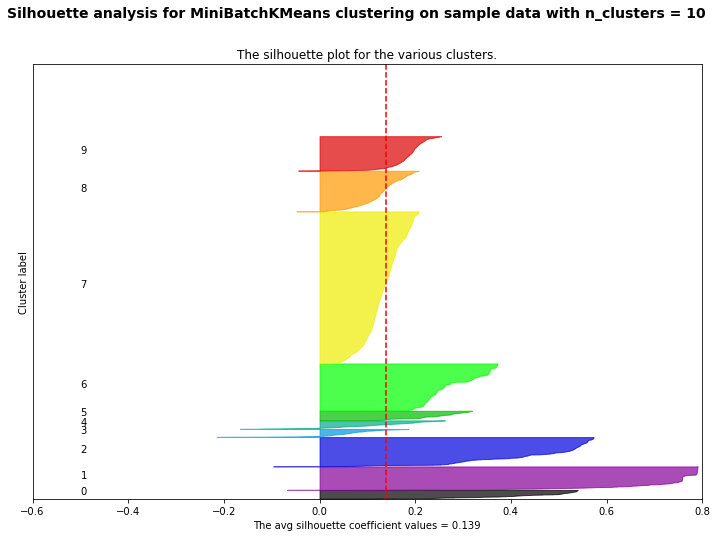

In [51]:
from sklearn.model_selection import ShuffleSplit
#svd_representation=X.copy()

ss = ShuffleSplit(n_splits=1, train_size=int(svd_representation.shape[0]*.2))
subs= ss.split(svd_representation)#,hdb.labels_

for index in subs:
    X=svd_representation[index[0]]#.tocsr()
    cluster_labels=hdb.labels_[index[0]]
                        
    hdb_t1 = time.time()
    
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(12, 8)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-.5, .5])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 12])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('Elapsed time to cluster: %6.1f m' % ((time.time()-hdb_t1)/60))
    print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    n_len=len(sample_silhouette_values[sample_silhouette_values<0])
    one_per=len(sample_silhouette_values)/100
    percent=round(n_len/one_per,2)
    print('Negative silhouette count: ',n_len,', ',percent,'%')
    if percent>=2: print('Плохой результат силуэта при кластеризации')#raise Exception
    
    y_lower = 12
    for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == i]
    
                ith_cluster_silhouette_values.sort()
    
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
    
                color = cm.spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)
    
                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.5, y_lower + 0.5 * size_cluster_i, str(i))
    
                # Compute the new y_lower for next plot
                y_lower = y_upper + 12  # 10 for the 0 samples
    
    set_xlabel="The avg silhouette coefficient values = "+str(round(silhouette_avg,3))
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel(set_xlabel)
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(list(np.arange(-.6,1,.2)))
    
    plt.suptitle(("Silhouette analysis for MiniBatchKMeans clustering on sample data "
                          "with n_clusters = %d" % n_clusters),
                         fontsize=14, fontweight='bold')
    
    plt.show()
    
    del X
    del cluster_labels